In [15]:
# Cell 1: 基础导入 & 加载配置
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.exp_config import get_config
from data_provider.data_loader import DataModule
from exp.exp_model import Model

# ==== 选择配置 ====
# 假设你已经在 exp_config 里写了一个 LZHModel 的配置
# 如果名字不同，就把 'LZHModelConfig' 改成你自己的
config = get_config('LZHModelConfig')

config.model = 'lzhmodel'
config.bs = 1

# 用 GPU / CPU
device = config.device
print("Using device:", device)


<module 'module.name' from 'configs/LZHModelConfig.py'> LZHModelConfig
Using device: cuda


In [17]:
# Cell 2: 构建 DataModule & 加载模型权重

class DummyLogger:
    def only_print(self, msg):
        print(msg)

config.log = DummyLogger()

# 构建 DataModule（会自动 load_data + 切分 + DataLoader）
datamodule = DataModule(config)

# 构建 LZHModel（是被 BasicModel 包了一层的 Model）
model = Model(config).to(device)
model.eval()

# ==== 加载训练好的权重 ====
# 路径规则和你 RunOnce 里是一样的：
# ./checkpoints/{config.model}/{log.filename}_round_{runId}.pt
# 这里建议你手动填一个你想看的 checkpoint 路径
model_ckpt = "./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt"  # TODO: 改成你真实的路径

state_dict = torch.load(model_ckpt, map_location=device)
model.load_state_dict(state_dict)
print("Loaded checkpoint from:", model_ckpt)


Train_length : 36696 Valid_length : 5078 Test_length : 10349
Loaded checkpoint from: ./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt


In [18]:
# Cell 3: 取一个 batch，计算 x_hat 和 y_hat

# 从 test_loader 里取一个 batch（因为 shuffle=False，可理解为“第一个样本”）
test_batch = next(iter(datamodule.test_loader))
# weather: x, x_mark, y
x, x_mark, y = [t.to(device) for t in test_batch]

print("x shape:", x.shape)        # [B, seq_len, C_x]
print("x_mark shape:", x_mark.shape)
print("y shape:", y.shape)        # [B, pred_len, C_y]

with torch.no_grad():
    # 1) 通过 diffusion_forward 得到 x_hat
    # 如果你的 LZHModel.diffusion_forward 还需要 x_mark，就改成：
    # x_hat = model.model.diffusion_forward(x, x_mark)
    x_hat = model.model.diffusion_forward(x)
    
    # 2) 正常前向得到 y_hat
    outputs = model(x, x_mark)
    if isinstance(outputs, tuple):
        y_hat, _ = outputs   # (pred, dcs_loss)
    else:
        y_hat = outputs

print("x_hat shape:", x_hat.shape)
print("y_hat shape:", y_hat.shape)


x shape: torch.Size([1, 96, 21])
x_mark shape: torch.Size([1, 96, 4])
y shape: torch.Size([1, 96, 21])
x_hat shape: torch.Size([1, 96, 21])
y_hat shape: torch.Size([1, 96, 21])


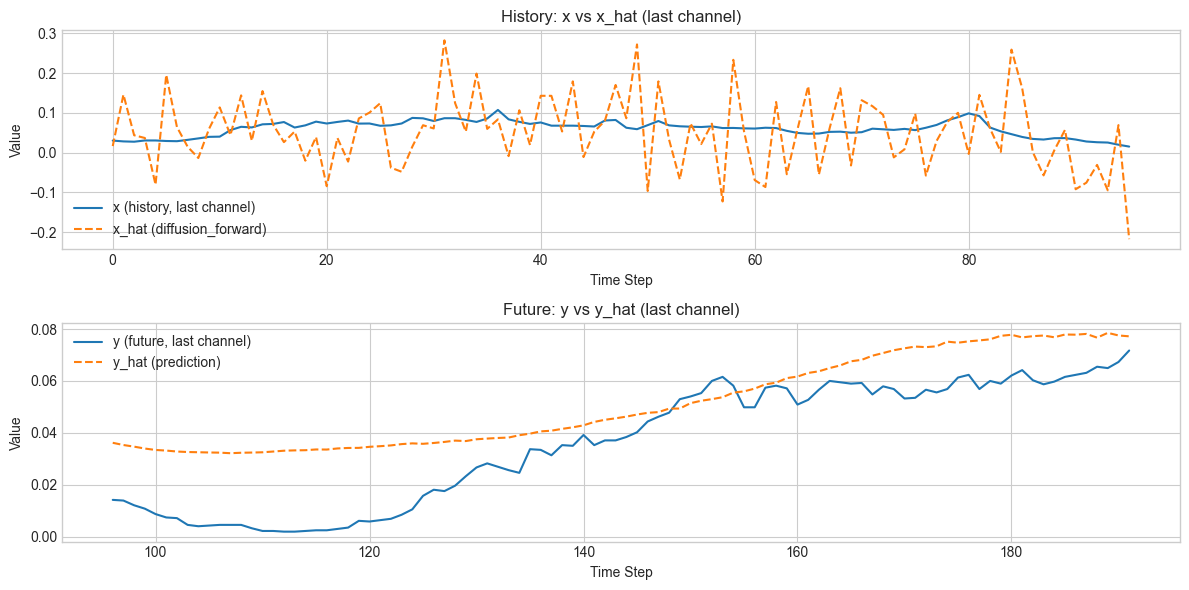

In [19]:
# Cell 4: 抽取 batch[0] 的最后一个通道并可视化

# 把 tensor -> numpy
x_np     = x[0].detach().cpu().numpy()        # [seq_len, C_x]
x_hat_np = x_hat[0].detach().cpu().numpy()    # [seq_len, C_x]
y_np     = y[0].detach().cpu().numpy()        # [pred_len, C_y]
y_hat_np = y_hat[0].detach().cpu().numpy()    # [pred_len, C_y]

# 取最后一个通道
x_last     = x_np[:, -1]
x_hat_last = x_hat_np[:, -1]
y_last     = y_np[:, -1]
y_hat_last = y_hat_np[:, -1]

seq_len   = x_last.shape[0]
pred_len  = y_last.shape[0]

t_hist   = np.arange(seq_len)
t_future = np.arange(seq_len, seq_len + pred_len)

plt.figure(figsize=(12, 6))

# 历史 x vs x_hat
plt.subplot(2, 1, 1)
plt.plot(t_hist, x_last, label='x (history, last channel)')
plt.plot(t_hist, x_hat_last, linestyle='--', label='x_hat (diffusion_forward)')
plt.legend()
plt.title('History: x vs x_hat (last channel)')
plt.xlabel('Time Step')
plt.ylabel('Value')

# 未来 y vs y_hat
plt.subplot(2, 1, 2)
plt.plot(t_future, y_last, label='y (future, last channel)')
plt.plot(t_future, y_hat_last, linestyle='--', label='y_hat (prediction)')
plt.legend()
plt.title('Future: y vs y_hat (last channel)')
plt.xlabel('Time Step')
plt.ylabel('Value')

plt.tight_layout()
plt.show()


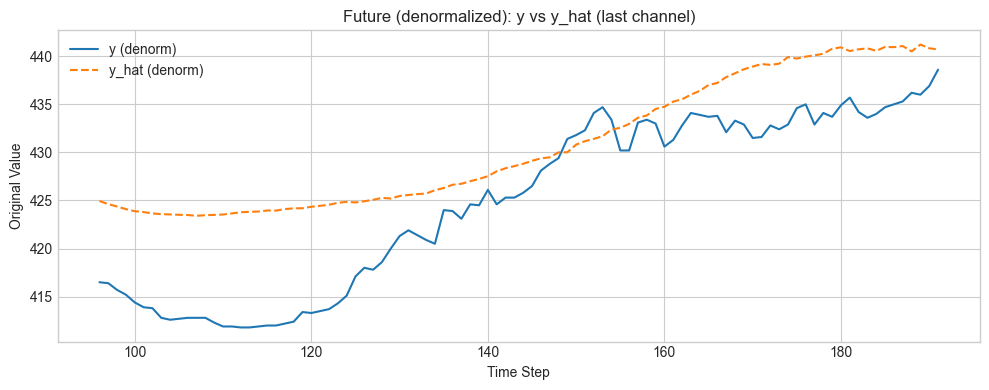

In [20]:
# Cell 5: 可选 - 把 y / y_hat 反归一化到原始数值再画

# 注意：y_scaler 是在 get_ts 里对所有通道一起 fit 的
y_denorm = datamodule.y_scaler.inverse_transform(y_np)
y_hat_denorm = datamodule.y_scaler.inverse_transform(y_hat_np)

y_last_denorm     = y_denorm[:, -1]
y_hat_last_denorm = y_hat_denorm[:, -1]

plt.figure(figsize=(10, 4))
plt.plot(t_future, y_last_denorm, label='y (denorm)')
plt.plot(t_future, y_hat_last_denorm, linestyle='--', label='y_hat (denorm)')
plt.legend()
plt.title('Future (denormalized): y vs y_hat (last channel)')
plt.xlabel('Time Step')
plt.ylabel('Original Value')
plt.tight_layout()
plt.show()
